In [1]:
import pandas as pd
import numpy as np
import re

import warnings
warnings.filterwarnings('ignore')

# Pottery glaze combination recommendations

One part of the process in creating pottery is glazing. A glaze is made largely of silica and aluminum oxide with other chemicals added to change the color and texture. Glazes can be painted/poured/dipped to coat a piece of pottery, then when heated to extremely high tempertatures the glaze creates a glass like coat over the piece. Many potters combine glazes to get different colors and create patterns. Combining glazes greates a chemical reaction when heated that makes the outcome not very predictable. Amaco is a popular commercial glaze company that has a large active community. Specifically, there is a facebook group called [AMACO Cone 5-6 Glaze Forum](https://docs.google.com/spreadsheets/d/1535tmfu3o4mzZges-OJC4llVHRYEM3lRESrZnrSl0og/edit?fbclid=IwAR2o6Et4Z31QqMWJBo_um8mPFM9RXmiEE7aGMOyN9y69aZKDxPQo4Ie7eMs#gid=1385339301) where potters post thier art and succesful glaze combinations. There are ~100 glazes currently being produced by amaco resulting in about ~10k possible combinations of two glazes. Despite this, the same combinations are posted over and over in this facebook group. This creates a relatively sparse matrix of combinations.

I have own several amaco glazes and am constantly trying to find new ways to combine them. With this project I want to answer a few questions:
- What are the best combinations I can create with my current set of glazes?
- Which combinations could be really popular, but almost no examples are posted?
- What is the best glaze to pair with my favorite glaze?
- If I were to buy a new glaze, which would pair the best with my current set of glazes?

I will tackle these questions with two methods:
1. Use content filtering and cosine similarity to identify glazes that pair well together
2. Use matrix factoriztion to predict the number of likes a combo will get

For the entire project, I will use number of 'Likes' as a proxy for the quality of a glaze combo.

## Data preparation
Raw text data is messy, and this data is no exception. I'll do a decent amount of data cleaning, but in reality cleaning this data could take as much time as I am willing to give it.

The first dataset has info about glaze names which will be used for cleaning the data and creating the recommendtaion matrix.

The second dataset is our raw facebook post text. The code for pulling this dataset is included in the github reprository.

In [2]:
#get data
name_info = pd.read_csv('Amaco PC Runniness Matrix - Glaze list (A-Z).csv')
posts = pd.read_csv('post_raw_data.csv')

In [3]:
posts.tail()

,Unnamed: 0,Text,Likes,Comments,Shares
110942,110942,Thank you for accepting me into this group - I...,0,0,0
110943,110943,This guideline works really well too. It is wh...,3,0,0
110944,110944,Deep Olive speckle over midnight blue (also us...,6,1,0
110945,110945,NaN,2,0,0
110946,110946,NaN,9,0,0


We see already that there are posts with no text. Not suprising, sometimies people just post pictures.

In [4]:
#drop missing posts
posts.drop_duplicates('Text',inplace=True)
posts = posts[~posts['Text'].isnull()].reset_index(drop=True)

In [5]:
name_info.head()

,Product\nPage,Product\nNum,Name,Other Common Name(s),Comment(s),Video URL(s),Dinnerware\nSafe
0,Detail,PC-32,Albany Slip Brown,"""ASB""",NaN,1) w/Chai Gloss Shino: https://www.facebook.c...,yes
1,Detail,PC-56,Ancient Copper,"""AC""",Ancient Copper does well when fired hot. But ...,https://www.facebook.com/groups/potterschoicee...,yes
2,Detail,PC-53,Ancient Jasper,"""AJ""; ""Ancient Jaspar""",NaN,NaN,yes
3,Detail,PC-21,Arctic Blue,"""AB""; ""Artic Blue""",NaN,NaN,yes
4,Detail,PC-48,Art Deco Green,"""ADG""; ""Art Deco""",NaN,NaN,yes


From this dataset I only care about the product number, name, and other commone names. I'll need to process the other names column to make it useful.

In [6]:
#Glazes are often called by many different names, I have a starting list for alt names, but I'll do some word frequency analysis to also check
name_info = name_info[['Product\nNum','Name','Other Common Name(s)']].rename({'Product\nNum':'prodId','Name':'name','Other Common Name(s)':'alt_name'}, axis='columns')

In [7]:
name_info['alt_name'] = name_info['alt_name'].str.replace('"', '')

In [8]:
name_info = name_info.set_index(['prodId','name'])

In [9]:
name_info = name_info['alt_name'].str.split('; ', expand=True).stack().reset_index()
name_info.drop('level_2',axis=1,inplace=True)

In addittion to the glaze info I imported, I will also add a long list of the glaze names and product ids

In [10]:
amaco_glazes = pd.DataFrame({'prodId':['PC-1','PC-10','PC-11','PC-12','PC-15','PC-16','PC-17','PC-2','PC-20','PC-21','PC-22','PC-23','PC-24','PC-25','PC-26','PC-27','PC-28','PC-29','PC-30','PC-31','PC-32','PC-33','PC-34','PC-36','PC-38','PC-4','PC-41','PC-42','PC-43','PC-44','PC-45','PC-46','PC-47','PC-48','PC-49','PC-52','PC-53','PC-55','PC-56','PC-57','PC-59','PC-61','PC-62','PC-63','PC-64','PC-67','PC-70','PC-71','PC-9','C-1','C-10','C-11','C-19','C-20','C-21','C-22','C-23','C-25','C-27','C-29','C-3','C-36','C-40','C-41','C-43','C-47','C-49','C-5','C-50','C-53','C-54','C-55','C-56','C-57','C-60','C-65','SM-1','SM-10','SM-11','SM-20','SM-21','SM-27','SM-29','SM-42','SM-51','SM-63','SM-68'],
                             'name':['Saturation Metallic','June Bug','Blue Spark','Blue Midnight','Satin Oribe','Purple Crystal','Honey Flux','Saturation Gold','Blue Rutile','Arctic Blue','Blue Stone','Indigo Float','Sapphire Float','Textured Turquoise','Blue Lagoon','Tourmaline','Frosted Turquoise','Deep Olive Speckle','Temmoku','Oatmeal','Albany Slip Brown','Iron Lustre','Light Sepia','Ironstone','Iron Yellow','Palladium','Vert Lustre','Seaweed','Toasted Sage','Sage','Dark Green','Lustrous Jade','Emerald Falls','Art Deco Green','Frosted Melon','Deep Sienna Speckle','Ancient Jasper','Chun Plum','Ancient Copper','Smokey Merlot','Deep Firebrick','Textured Amber','Textured Amber Brown','Cosmic Tea Dust','Aventurine','River Rock','Copper Red','Flambe','Vintage Gold','Obsidian','Snow','Mixing Clear','Glacier','Cobalt','Sky','Fog','Ice','Downpour','Storm','Deep Sea','Smoke','Iron','Aqua','Pear','Wasabi','Jade','Rainforest','Charcoal','Cherry Blossom','Weeping Plum','Snapdragon','Poppy','Lavender','Mulberry','Marigold','Tangelo','Black Satin Matte','Clear Satin Matte','White Satin Matte','Light Blue Satin Matte','Dark Blue Satin Matte','Teal Satin Matte','Blue Green Satin Matte','Mint Satin Matte','Red Satin Matte','Yellow Satin Matte','Orange Satin Matte']})

In [11]:
name_info = name_info[~(name_info[0]=="IF")]
name_info = name_info.append(amaco_glazes,ignore_index=True)

In [12]:
name_info.head()

,prodId,name,0
0,PC-32,Albany Slip Brown,ASB
1,PC-56,Ancient Copper,AC
2,PC-53,Ancient Jasper,AJ
3,PC-53,Ancient Jasper,Ancient Jaspar
4,PC-21,Arctic Blue,AB


Now we need to do text processing. These functions are copied from a project I have completed previously for work. The preprocess function gets rid of punctuation and makes everything lower case. The get_top_n_words creates a corpus for each post and finds the most frequent word combinations of length n. I've found this to be incredibly helpful for identifying content specific stop words.

In [13]:
# Separate posts into corpus, count bigram, trigram occurences
from sklearn.feature_extraction.text import CountVectorizer

def preprocess(ReviewText):
    ReviewText = ReviewText.str.replace("’", "")
    ReviewText = ReviewText.str.replace("'", "")
    ReviewText = ReviewText.str.replace("(&#39)", "")
    ReviewText = ReviewText.str.replace("(<br/>)", "")
    ReviewText = ReviewText.str.replace('(<a).*(>).*(</a>)', '')
    ReviewText = ReviewText.str.replace('(&amp)', '')
    ReviewText = ReviewText.str.replace('(&gt)', '')
    ReviewText = ReviewText.str.replace('(&lt)', '')
    ReviewText = ReviewText.str.replace('(\xa0)', ' ')
    ReviewText = ReviewText.str.replace('questions', 'question')
    return ReviewText.str.lower()

def get_top_n_words(corpus, num_grams, n=None):
    vec = CountVectorizer(ngram_range=(num_grams,num_grams), stop_words=stopWords).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as esw
esw = list(esw)

In [14]:
posts['Text'] = preprocess(posts['Text'])

I'm going to iteratively build a list of frequently used words that I do not care about to remove starting with the glaze names we already know and english stop words. Additionally I will add other glazes it they appear frequently. The two cells below are the final result of that iterative process.

In [15]:
new_names = pd.DataFrame({'prodId':['SW-155','SW-155','SW-101'],
         'name':['Winter Wood','Winter Wood','Stoned Denim'],
         0:['winterwood','ww',None]
        })
name_info = name_info.append(new_names, ignore_index=True)

In [16]:
#I'm going to iteratively build a list of frequently used words that I do not care about to remove
#starting with the glaze names we already know and english stop words

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as esw
esw = list(esw)
glazes_idd = sum(name_info['name'].str.lower().str.split(' '), []) + sum(name_info[0].astype('str').str.lower().str.split(' '), [])
other_remove = ['amaco','brent','glaze','youtube','channel','fans','new','york','city','time','zone','ceramic','mending','used',
                'live','cone','minute','hold','stoneware','clay','mug','shot','monday','potters','choice','glazesfired','use',
                'community','kiln','laguna','speckled','buff','thought','id','share','https','facebook','www','instagram','firing',
                'com','standard','1x','2x','3x','4x','5x','x1','x2','x3','x4','x5','fired','bisque','slow','cool','pc','glazes',
                'velvet','underglaze','inside','outside','min','10','looks','like','coats','test','tiles','im','looking','know','thanks',
               'rim','dont','want','zinc','free','food','safe','combos','years','got','just','little','loafers','hand','built','mudworks',
               'love','help','need','good','morning','ive','seen','wax','resist','happy','does','question','half','greatly','run','cones',
               'schedule','bowl','thank','piece','pieces','did','mix','really','think']

stopWords = esw + glazes_idd + other_remove

In [17]:
common_words = get_top_n_words(posts['Text'], 1, 30)
df1 = pd.DataFrame(common_words, columns = ['survey_response_value' , 'count'])

common_words = get_top_n_words(posts['Text'], 2, 100)
df2 = pd.DataFrame(common_words, columns = ['survey_response_value' , 'count'])

common_words = get_top_n_words(posts['Text'], 3, 30)
df3 = pd.DataFrame(common_words, columns = ['survey_response_value' , 'count'])

In [18]:
df2.head()

,survey_response_value,count
0,oil spot,579
1,left right,550
2,medium speed,405
3,stroke coat,392
4,base coat,355


This method was less effective than expected, I'm moving on to other data cleaning
however this is our list of glazes we will be working with. 
Additionally I'm dropping a few glazes because they are unpopular, but have generic names so are way over extracting


In [19]:
glaze_set = name_info[['prodId','name']].drop_duplicates().sort_values('prodId').reset_index(drop=True)
glaze_set = glaze_set[~(glaze_set['name'].isin(['Iron','Ice']))].reset_index(drop=True)
print(len(glaze_set))

89


My next task is extracting the glazes used in each post

In [20]:
#creating a boolean matrix for whether a glaze or it's alt names were found
#initalize a matrix of 0's that is the size of our glazes x posts
post_glaze_matrix = np.full((len(glaze_set), len(posts)), 0)


for g in range(len(glaze_set)):
    #for each glaze get a list of possible names
    possible_names = [glaze_set['name'][g]] + list(name_info[name_info['name']==glaze_set['name'][g]][0].dropna())
   # print(possible_names)
    
    #find whether each name is listed
    glaze_listed = [0] * len(posts)
    for n in possible_names:
        #The glazes with two letter alternate names were way over extracting, 
        #so I need to make the reg expression more complex
        if len(n)<=5:
            search = "[ x]{1}"+n+"[ x]{1}"
        else:
            search = n
            
        glaze_listed = np.max([glaze_listed, posts['Text'].str.contains(search,case=False)*1],axis=0)
        
    post_glaze_matrix[g] = glaze_listed

Now we can do some descriptive on how often glazes are used 

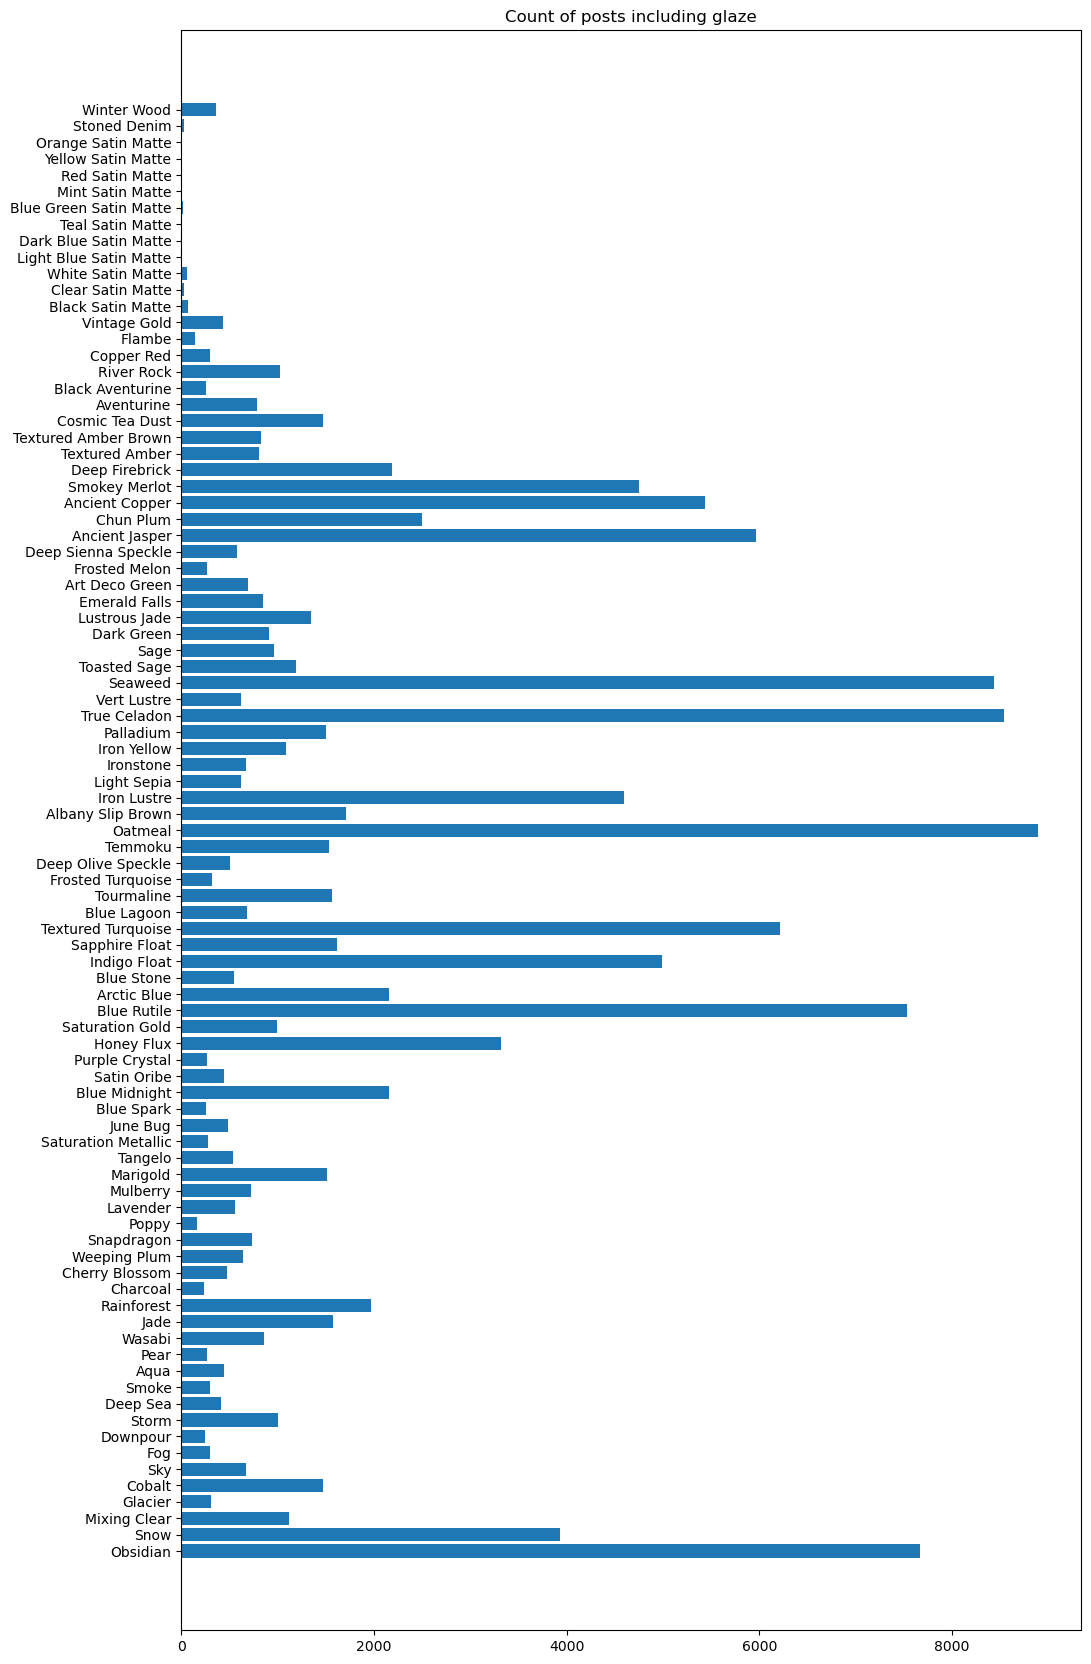

In [21]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize =(9, 16))
ax = fig.add_axes([0,0,1,1])
ax.set_title('Count of posts including glaze')
cats = glaze_set['name']
counts = post_glaze_matrix.sum(axis=1)
ax.barh(cats,counts)
#ax.invert_xaxis()
plt.show()

This graph now reads pretty true to me. Let's look at glazes were extracted from each post.

(array([3.9269e+04, 2.1301e+04, 1.9065e+04, 1.0682e+04, 4.6230e+03,
        2.0260e+03, 9.6100e+02, 4.6200e+02, 2.4600e+02, 1.2700e+02,
        8.0000e+01, 3.9000e+01, 2.6000e+01, 2.1000e+01, 1.6000e+01,
        1.6000e+01, 5.0000e+00, 4.0000e+00, 1.0000e+00, 3.0000e+00,
        6.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36.]),
 <BarContainer object of 36 artists>)

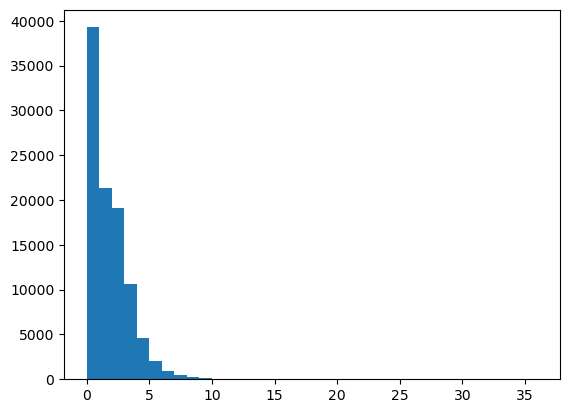

In [22]:
#Let's look at glazes per post now
counts, bins = np.histogram(np.sum(post_glaze_matrix,axis=0),max(np.sum(post_glaze_matrix,axis=0)))
plt.hist(bins[:-1], bins, weights=counts)

There are a huge number of posts with 0 or 1 glaze extracted. Not surprising, facebook posts are very unstructured and even if this post contained a glaze combo it could be in the comments or in the image/image description. Considering this project is about combos, we need at least two glazes in every post

In [23]:
#dropping posts with no glazes or 1 glaze extracted
posts = posts[np.sum(post_glaze_matrix,axis=0) > 1]
post_glaze_matrix = post_glaze_matrix[:,np.sum(post_glaze_matrix,axis=0) > 1]
print(post_glaze_matrix.shape)

(89, 38414)


## Data preparation
To conduct my analyses I need two matrixes of size #glazes x #glazes

- post_glaze_matrix will count the number of posts that mention both glazes
- glaze_likes_matrix will average the number of likes posts that mention both glazes get

In [24]:
glaze_paired_matrix = np.full((len(glaze_set), len(glaze_set)), 0.0)
for g in range(len(glaze_set['name'])):
    for c in range(len(glaze_set['name'])):
        glaze_paired_matrix[g,c] = sum(post_glaze_matrix [g]*post_glaze_matrix [c])
        
glaze_likes_matrix = np.full((len(glaze_set), len(glaze_set)), 0)
for g in range(len(glaze_set['name'])):
    for c in range(len(glaze_set['name'])):
        rows = np.nan_to_num(post_glaze_matrix [g]*post_glaze_matrix [c])
        if sum(rows)>0:
            glaze_likes_matrix[g,c] = np.mean(posts['Likes'][rows.astype('bool')])

# Analysis
## Glaze similarity with content filtering
Based on the glaze_likes_matrix I'm going to calculate the cosine similarity between glazes. 

In [25]:
import sklearn.metrics

In [26]:
standardized_glaze_pairs = (glaze_paired_matrix/np.sum(glaze_paired_matrix, axis=0))

In [27]:
sim_glaze_pairs = sklearn.metrics.pairwise.cosine_similarity(standardized_glaze_pairs)

## Predicting likes with svd matrix factorization
I choose svd matrix factorization because it preforms well with sparse matrices

In [28]:
from scipy.sparse.linalg import svds

In [29]:
glaze_likes_matrix = np.where(glaze_likes_matrix==0,np.NaN,glaze_likes_matrix)

In [30]:
glaze_ratings_mean = np.nanmean(glaze_likes_matrix, axis = 1)
matrix_centered = glaze_likes_matrix - glaze_ratings_mean.reshape(-1, 1)

In [31]:
matrix_centered = np.nan_to_num(matrix_centered)

In [32]:
U, sigma, Vt = svds(matrix_centered,k=3)
sigma = np.diag(sigma)

In [33]:
glaze_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + glaze_ratings_mean.reshape(-1, 1)

Now I'm just going to put our results in a dataframe to easily share the results

In [34]:
#convert to a df for convenience filtering with columns for similarity, frequency of posts, avg_likes, and predicted_likes
results_df = pd.DataFrame(sim_glaze_pairs).reset_index().melt('index')
results_df = results_df.rename(columns={'index':'glaze_1','variable':'glaze_2','value':'similarity'})

glaze_paired_freq = pd.DataFrame(glaze_paired_matrix).reset_index().melt('index')
glaze_paired_freq = glaze_paired_freq.rename(columns={'index':'glaze_1','variable':'glaze_2','value':'frequency'})

glaze_paired_likes = pd.DataFrame(glaze_likes_matrix).reset_index().melt('index')
glaze_paired_likes = glaze_paired_likes.rename(columns={'index':'glaze_1','variable':'glaze_2','value':'avg_likes'})

glaze_predict_likes = pd.DataFrame(glaze_predicted_ratings).reset_index().melt('index')
glaze_predict_likes = glaze_predict_likes.rename(columns={'index':'glaze_1','variable':'glaze_2','value':'predicted_likes'})

results_df = results_df.merge(glaze_paired_freq, on=['glaze_1','glaze_2']).merge(glaze_paired_likes, on=['glaze_1','glaze_2']).merge(glaze_predict_likes, on=['glaze_1','glaze_2'])
results_df = results_df[results_df.glaze_1<results_df.glaze_2].reset_index(drop=True)

results_df['glaze_1'] = results_df['glaze_1'].apply(lambda x: glaze_set['name'][x])
results_df['glaze_2'] = results_df['glaze_2'].apply(lambda x: glaze_set['name'][x])

## What are the most popular glaze combinations?

In [36]:
results_df.sort_values('frequency',ascending=False).head(10)

,glaze_1,glaze_2,similarity,frequency,avg_likes,predicted_likes
683,Obsidian,Seaweed,0.685898,2362.0,88.0,75.008799
911,Obsidian,Smokey Merlot,0.702123,1882.0,90.0,77.638698
716,Oatmeal,Seaweed,0.694855,1757.0,80.0,76.030600
464,Blue Rutile,Oatmeal,0.693203,1448.0,81.0,71.203168
708,Blue Rutile,Seaweed,0.678378,1413.0,79.0,69.649820
711,Indigo Float,Seaweed,0.670836,1398.0,86.0,65.220969
953,Seaweed,Smokey Merlot,0.648424,1382.0,89.0,86.149420
938,Blue Rutile,Smokey Merlot,0.623778,1041.0,81.0,74.649261
340,Blue Rutile,Textured Turquoise,0.558787,1032.0,88.0,74.031927
467,Indigo Float,Oatmeal,0.601978,1015.0,77.0,65.547807


# Results
- What are the best combinations I can create with my current set of glazes?
- Which combinations could be really popular, but almost no examples are posted?
- What is the best glaze to pair with my favorite glaze?
- If I were to buy a new glaze, which would pair the best with my current set of glazes?

In [37]:
#These are my current glazes
glazes_owned = ['Winter Wood','Obsidian','Ancient Jasper', 'Textured Turqoise', 'Smokey Merlot','Seaweed','Oatmeal','Blue Midnight','Arctic Blue','Art Deco Green','Deep Olive Speckle','Snow']

## What are the best combinations I can create with my current set of glazes?
The most popular combinations based on average likes and the predicted likes from our matrix factorization

In [38]:
results_mine = results_df[(results_df['glaze_1'].isin(glazes_owned))&(results_df['glaze_2'].isin(glazes_owned))]
len(results_mine)

30

### Average likes (observed data)

In [39]:
results_mine.sort_values('avg_likes',ascending=False).head(10)

,glaze_1,glaze_2,similarity,frequency,avg_likes,predicted_likes
1914,Smokey Merlot,Winter Wood,0.141141,37.0,169.0,95.764716
405,Arctic Blue,Deep Olive Speckle,0.096363,15.0,140.0,93.562169
1849,Obsidian,Winter Wood,0.090955,19.0,139.0,80.426464
1850,Snow,Winter Wood,0.081928,20.0,134.0,83.863654
1877,Blue Midnight,Winter Wood,0.100219,17.0,126.0,76.927727
1908,Art Deco Green,Winter Wood,0.057733,9.0,125.0,97.599412
945,Deep Olive Speckle,Smokey Merlot,0.173807,51.0,115.0,86.242230
958,Art Deco Green,Smokey Merlot,0.131495,32.0,114.0,80.843293
1911,Ancient Jasper,Winter Wood,0.113836,30.0,107.0,97.202291
709,Arctic Blue,Seaweed,0.449653,471.0,99.0,76.855382


### Precited likes (predicted data)

In [40]:
results_mine.sort_values('predicted_likes',ascending=False).head(10)

,glaze_1,glaze_2,similarity,frequency,avg_likes,predicted_likes
1891,Deep Olive Speckle,Winter Wood,0.031071,0.0,NaN,98.458961
1908,Art Deco Green,Winter Wood,0.057733,9.0,125.0,97.599412
1883,Arctic Blue,Winter Wood,0.061383,6.0,55.0,97.424372
1911,Ancient Jasper,Winter Wood,0.113836,30.0,107.0,97.202291
1902,Seaweed,Winter Wood,0.150638,41.0,95.0,96.046738
1914,Smokey Merlot,Winter Wood,0.141141,37.0,169.0,95.764716
405,Arctic Blue,Deep Olive Speckle,0.096363,15.0,140.0,93.562169
1893,Oatmeal,Winter Wood,0.163138,53.0,96.0,86.345308
945,Deep Olive Speckle,Smokey Merlot,0.173807,51.0,115.0,86.242230
953,Seaweed,Smokey Merlot,0.648424,1382.0,89.0,86.149420


From the list of 55 glaze combinations I could make with my current set of glazes, the top 10 predicted combos for predicted vs. observed had 50% overlap. The top predicted combo 'Seaweed' and 'Winter Wood' I have tried and am not particularly fond of. 

## Which combinations could be really popular, but almost no examples are posted?
The most popular combinations which fewer than 10 posts have been created.

In [41]:
results_df[results_df['frequency']<10].sort_values('predicted_likes',ascending=False).head(10)

,glaze_1,glaze_2,similarity,frequency,avg_likes,predicted_likes
100,Cobalt,Poppy,0.038627,2.0,469.0,324.579572
1816,Albany Slip Brown,Stoned Denim,0.119627,4.0,180.0,220.521241
1837,Black Aventurine,Stoned Denim,0.000348,0.0,NaN,209.921344
1124,Albany Slip Brown,Black Aventurine,0.053508,8.0,292.0,207.213525
1825,Lustrous Jade,Stoned Denim,0.031716,1.0,488.0,205.756734
1831,Chun Plum,Stoned Denim,0.092071,3.0,246.0,200.729928
1834,Deep Firebrick,Stoned Denim,0.092344,3.0,217.0,197.991587
1838,River Rock,Stoned Denim,0.092946,3.0,266.0,195.020256
147,Storm,Tangelo,0.065142,5.0,208.0,193.645429
1935,Stoned Denim,Winter Wood,0.104163,3.0,172.0,193.298841


The list of glazes that are predicted to be very popular, but have fewer than 10 posts is largely dominated by Ice and Stoned Denim. These are both not very frequent occurances on the glaze forum, so it's possible there is just not much data to go on. Or maybe these combinations are fantastic and just waiting to be discovered? 

## Which is the best glaze to pair with my favorite glaze?
I will answer this question in two ways, first the glazes with the highest similarity to my favorite glaze and second the glazes with the highest predicted likes to my favorite glaze.

In [42]:
favorite='Blue Midnight'
results_fav = results_df[(results_df['glaze_1']==favorite)|(results_df['glaze_2']==favorite)]

### Most similar

In [43]:
results_fav.sort_values('similarity',ascending=False).head(10)

,glaze_1,glaze_2,similarity,frequency,avg_likes,predicted_likes
262,Blue Midnight,Blue Rutile,0.473876,488.0,67.0,72.716033
278,Blue Midnight,Indigo Float,0.446096,414.0,80.0,70.815729
703,Blue Midnight,Seaweed,0.418336,465.0,79.0,71.865510
462,Blue Midnight,Oatmeal,0.407626,435.0,83.0,72.643243
335,Blue Midnight,Textured Turquoise,0.367083,405.0,92.0,72.448278
933,Blue Midnight,Smokey Merlot,0.326740,211.0,55.0,73.492591
480,Blue Midnight,Iron Lustre,0.310332,187.0,61.0,72.762308
902,Blue Midnight,Chun Plum,0.268521,132.0,82.0,75.598265
373,Blue Midnight,Tourmaline,0.261773,110.0,73.0,71.099049
502,Blue Midnight,Light Sepia,0.249096,92.0,82.0,74.132508


### Higest predicted likes

In [44]:
results_fav.sort_values('predicted_likes',ascending=False).head(10)

,glaze_1,glaze_2,similarity,frequency,avg_likes,predicted_likes
1802,Blue Midnight,Stoned Denim,0.061033,2.0,8.0,83.557970
1877,Blue Midnight,Winter Wood,0.100219,17.0,126.0,76.927727
1148,Blue Midnight,River Rock,0.108687,29.0,83.0,76.724152
902,Blue Midnight,Chun Plum,0.268521,132.0,82.0,75.598265
208,Blue Midnight,Satin Oribe,0.068339,9.0,141.0,75.547122
853,Blue Midnight,Emerald Falls,0.179462,50.0,145.0,75.281648
831,Blue Midnight,Lustrous Jade,0.181437,83.0,87.0,74.861492
542,Blue Midnight,Iron Yellow,0.123544,38.0,121.0,74.621123
1066,Blue Midnight,Textured Amber Brown,0.091311,27.0,64.0,74.534716
969,Blue Midnight,Deep Firebrick,0.215091,93.0,98.0,74.529898


Similarity in this case means they are often paired with the same glazes. It makes sense to look at glazes in this fashion because similar glazes will have similar chemical reaction when combine. I am familar with all the combinations on the similarity list and I know they look stunning together. 

Yet again Ice makes a top appearance on our predicted likes list. Ice, poppy and downpour are all a type of glaze that I don't think combine particularly well, so I don't trust the results very much here.

# If I were to buy a new glaze, which would pair the best with my current set of glazes?
I will answer this question in two ways, first the glazes with the highest similarity to my favorite glaze and second the glazes with the highest predicted likes to my favorite glaze.

In [45]:
includes_one = results_df[results_df['glaze_2'].isin(glazes_owned)*1 + results_df['glaze_1'].isin(glazes_owned)*1 ==1]

## Average similarity

In [46]:
sim_combo_ratings = ((includes_one.groupby('glaze_2')['similarity'].sum() + includes_one.groupby('glaze_1')['similarity'].sum())/len(glazes_owned)).sort_values(ascending=False)
top_unowned_sim = sim_combo_ratings.loc[set(sim_combo_ratings.index) - set(glazes_owned)].sort_values(ascending=False)
top_unowned_sim.head(10)

Indigo Float            0.236760
Blue Rutile             0.234637
True Celadon            0.164994
Iron Lustre             0.149731
Chun Plum               0.138294
Textured Turquoise      0.124909
Honey Flux              0.124207
Textured Amber Brown    0.122984
Textured Amber          0.121983
Palladium               0.117657
Name: similarity, dtype: float64

## Average predicted likes

In [47]:
mean_combo_ratings = ((includes_one.groupby('glaze_2')['predicted_likes'].sum() + includes_one.groupby('glaze_1')['predicted_likes'].sum())/len(glazes_owned)).sort_values(ascending=False)
top_unowned_likes = mean_combo_ratings.loc[set(mean_combo_ratings.index) - set(glazes_owned)].sort_values(ascending=False)
top_unowned_likes.head(10)

Stoned Denim            128.615688
Teal Satin Matte         73.215595
Vintage Gold             71.273903
White Satin Matte        69.141399
Textured Amber           68.057207
Textured Amber Brown     68.044814
River Rock               62.776767
Blue Stone               62.424585
Red Satin Matte          57.149799
Iron Yellow              49.994896
Name: predicted_likes, dtype: float64

According to my predictions, Blue Rutile or Stoned Denim should pair best with my currently owned glazes. The listed create dby similarity and th elist created with predicted likes are mutually exclusive. The predicted likes surfaces many more glazes that are rarely posted. The Similarity list surfaces quite popular glazes. 